In [11]:
#https://cooltools.readthedocs.io/en/latest/notebooks/viz.html

#Import the packages we will use
#Utilities
import os
import re
import itertools
from itertools import combinations
import glob
import pickle
import argparse

#Data Management
import numpy as np
from numpy import diff
import pandas as pd
import h5py
import scipy
from scipy.stats import linregress
from scipy import ndimage
from functools import partial
from scipy.linalg import toeplitz

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import upsetplot
from upsetplot import UpSet

#Genomics
import pairtools
import cooler
import cooltools
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools.insulation import calculate_insulation_score, find_boundaries
import bioframe
import cooltools.expected
import cooltools.saddle
from cooltools import snipping
from bioframe import overlap

In [3]:
#Using previously processed mapq30 filtered and sampled to the same read-depth within each experiment cooler files

In [4]:
outDataDir = '/nl/umw_job_dekker/users/eh37w/Topo-Inhib/Manuscript_Organized_August2021/Figure1_HeLa_ICRF_HiC'

conditions = [
    'AS_DMSO_R1',
    'AS_ICRF_R1',
    'MR_t4DMSO_R1',
    'MR_t4ICRF_R1',
    'MR_t8DMSO_R1',
    'MR_t8ICRF_R1',
    'AS_DMSO_R2',
    'AS_ICRF_R2',
    'MR_t4DMSO_R2',
    'MR_t4ICRF_R2',
    'MR_t8DMSO_R2',
    'MR_t8ICRF_R2',
    'AS_DMSO_R1R2',
    'AS_ICRF_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t8ICRF_R1R2'
]

long_names = {
    'AS_DMSO_R1' : 'TI-HiC-Dpn-HeLa-G1Sort-DMSO-2hr-4-29-R1-T1',
    'AS_ICRF_R1' : 'TI-HiC-Dpn-HeLa-G1Sort-ICRF-2hr-4-29-R1-T1',
    'MR_t4DMSO_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-DMSO-2hr-G1Sort-4-44-R1-T1',
    'MR_t4ICRF_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-ICRF-2hr-G1Sort-4-44-R1-T1',
    'MR_t8DMSO_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-DMSO-6hr-G1Sort-4-44-R1-T1',
    'MR_t8ICRF_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-ICRF-6hr-G1Sort-4-44-R1-T1',
    'AS_DMSO_R2' : 'TI-HiC-Dpn-HeLa-G1Sort-DMSO-2hr-4-48-R2-T1',
    'AS_ICRF_R2' : 'TI-HiC-Dpn-HeLa-G1Sort-ICRF-2hr-4-48-R2-T1',
    'MR_t4DMSO_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-DMSO-2hr-G1Sort-4-49-R2-T1',
    'MR_t4ICRF_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-ICRF-2hr-G1Sort-4-49-R2-T1',
    'MR_t8DMSO_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-DMSO-6hr-G1Sort-4-49-R2-T1',
    'MR_t8ICRF_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-ICRF-6hr-G1Sort-4-49-R2-T1',
    'AS_DMSO_R1R2' : 'TI-HiC-Dpn-HeLa-G1Sort-DMSO-2hr-R1R2',
    'AS_ICRF_R1R2' : 'TI-HiC-Dpn-HeLa-G1Sort-ICRF-2hr-R1R2',
    'MR_t4DMSO_R1R2': 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-DMSO-2hr-G1Sort-R1R2',
    'MR_t4ICRF_R1R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-ICRF-2hr-G1Sort-R1R2',
    'MR_t8DMSO_R1R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-DMSO-6hr-G1Sort-R1R2',
    'MR_t8ICRF_R1R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-ICRF-6hr-G1Sort-R1R2'
}

In [5]:
ComboConds = [
    'AS_DMSO_R1R2',
    'AS_ICRF_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t8ICRF_R1R2',
]

SepConds = [
    'AS_DMSO_R1',
    'AS_ICRF_R1',
    'MR_t4DMSO_R1',
    'MR_t4ICRF_R1',
    'MR_t8DMSO_R1',
    'MR_t8ICRF_R1',
    'AS_DMSO_R2',
    'AS_ICRF_R2',
    'MR_t4DMSO_R2',
    'MR_t4ICRF_R2',
    'MR_t8DMSO_R2',
    'MR_t8ICRF_R2'
]

ComboCtrlConds = [
    'AS_DMSO_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t8DMSO_R1R2'
]

ComboTreatConds = [
    'AS_ICRF_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8ICRF_R1R2'
]

SepCtrlConds = [
    'AS_DMSO_R1',
    'MR_t4DMSO_R1',
    'MR_t8DMSO_R1',
    'AS_DMSO_R2',
    'MR_t4DMSO_R2',
    'MR_t8DMSO_R2'
]

SepTreatConds = [
    'AS_ICRF_R1',
    'MR_t4ICRF_R1',
    'MR_t8ICRF_R1',
    'AS_ICRF_R2',
    'MR_t4ICRF_R2',
    'MR_t8ICRF_R2'
]

In [6]:
#add colors for each sample

sampleColors = {
    'AS_DMSO_R1' : '#98DFEA',
    'AS_ICRF_R1' : '#E1B7A3',
    'MR_t4DMSO_R1' : '#17BECF',
    'MR_t4ICRF_R1' : '#D62728',    
    'MR_t8DMSO_R1' : '#0D6871',
    'MR_t8ICRF_R1' : '#751616',
    'AS_DMSO_R2' : '#98DFEA',
    'AS_ICRF_R2' : '#E1B7A3',
    'MR_t4DMSO_R2' : '#17BECF',
    'MR_t4ICRF_R2' : '#D62728',    
    'MR_t8DMSO_R2' : '#0D6871',
    'MR_t8ICRF_R2' : '#751616',
    'AS_DMSO_R1R2' : '#98DFEA',
    'AS_ICRF_R1R2' : '#E1B7A3',
    'MR_t4DMSO_R1R2' : '#17BECF',
    'MR_t4ICRF_R1R2' : '#D62728',    
    'MR_t8DMSO_R1R2' : '#0D6871',
    'MR_t8ICRF_R1R2' : '#751616',
}

sampleLineStyles = {
    'AS_DMSO_R1' : '-',
    'AS_ICRF_R1' : '-',
    'MR_t4DMSO_R1' : '-',
    'MR_t4ICRF_R1' : '-',  
    'MR_t8DMSO_R1' : '-',
    'MR_t8ICRF_R1' : '-',
    'AS_DMSO_R2' : ':',
    'AS_ICRF_R2' : ':',
    'MR_t4DMSO_R2' : ':',
    'MR_t4ICRF_R2' : ':',   
    'MR_t8DMSO_R2' : ':',
    'MR_t8ICRF_R2' : ':',
    'AS_DMSO_R1R2' : '-',
    'AS_ICRF_R1R2' : '-',
    'MR_t4DMSO_R1R2' : '-',
    'MR_t4ICRF_R1R2' : '-',   
    'MR_t8DMSO_R1R2' : '-',
    'MR_t8ICRF_R1R2' : '-',
}

samplePlotNames = {
    'AS_DMSO_R1' : 'AS DMSO, R1',
    'AS_ICRF_R1' : 'AS ICRF-193, R1',
    'MR_t4DMSO_R1' : 'MR t4 DMSO, R1',
    'MR_t4ICRF_R1' : 'MR t4 ICRF-193, R1', 
    'MR_t8DMSO_R1' : 'MR t8 DMSO, R1',
    'MR_t8ICRF_R1' : 'MR t8 ICRF-193, R1',
    'AS_DMSO_R2' : 'AS DMSO, R2',
    'AS_ICRF_R2' : 'AS ICRF-193, R2',
    'MR_t4DMSO_R2' : 'MR t4 DMSO, R2',
    'MR_t4ICRF_R2' : 'MR t4 ICRF-193, R2', 
    'MR_t8DMSO_R2' : 'MR t8 DMSO, R2',
    'MR_t8ICRF_R2' : 'MR t8 ICRF-193, R2',
    'AS_DMSO_R1R2' : 'AS DMSO',
    'AS_ICRF_R1R2' : 'AS ICRF-193',
    'MR_t4DMSO_R1R2' : 'MR t4 DMSO',
    'MR_t4ICRF_R1R2' : 'MR t4 ICRF-193',   
    'MR_t8DMSO_R1R2' : 'MR t8 DMSO',
    'MR_t8ICRF_R1R2' : 'MR t8 ICRF-193'
}

In [12]:
#Heatmaps with eigenvectors - 250kb bins

In [13]:
#coolers - 250kb bins
binsize = 250000

clr_paths_250kb = {}
for cond in conditions:
    clr_paths_250kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs250kb = {
    cond: cooler.Cooler(clr_paths_250kb[cond]) for cond in conditions
}

In [14]:
good_chroms = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21']

In [15]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes_all = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(hg38_chromsizes_all,  hg38_cens))

In [16]:
# Select only chromosomes that are present in the cooler.
hg38_chromsizes = hg38_chromsizes_all.loc[good_chroms]
hg38_arms = hg38_arms[hg38_arms['chrom'].isin(good_chroms)]

In [17]:
bins = cooler.binnify(hg38_chromsizes, binsize)

In [18]:
from bioframe.io.resources import UCSCClient
mrna = UCSCClient('hg38').fetch_mrna()

In [19]:
genecov = bioframe.frac_gene_coverage(bins, mrna) 

In [20]:
genecov.head()

,chrom,start,end,coverage,count
0,chr4,0,250000,152618,781
1,chr4,250000,500000,240641,1483
2,chr4,500000,750000,159353,934
3,chr4,750000,1000000,220790,1270
4,chr4,1000000,1250000,238261,783


In [21]:
#Get compartments, flip based on gene density, good chroms by arm only
#Not sorting by variance compared to gene density, instead by variance explained of data

from cooltools.eigdecomp import cooler_cis_eig

lam = {}
eigs = {}

for cond in conditions:
    lam[cond], eigs[cond] = cooler_cis_eig(
        clrs250kb[cond], 
        genecov,
        n_eigs=3, 
        phasing_track_col='count', 
        ignore_diags=2,
        view_df = hg38_arms
    )

In [22]:
for cond in conditions:
    # Save text files
    lam[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.lam.txt', sep='\t')


In [23]:
hg38_arms.head()

,chrom,start,end,name
6,chr4,0,50728006,chr4:0-50728006
7,chr4,50728006,190214555,chr4:50728006-190214555
26,chr14,0,17086761,chr14:0-17086761
27,chr14,17086761,107043718,chr14:17086761-107043718
32,chr17,0,24714921,chr17:0-24714921


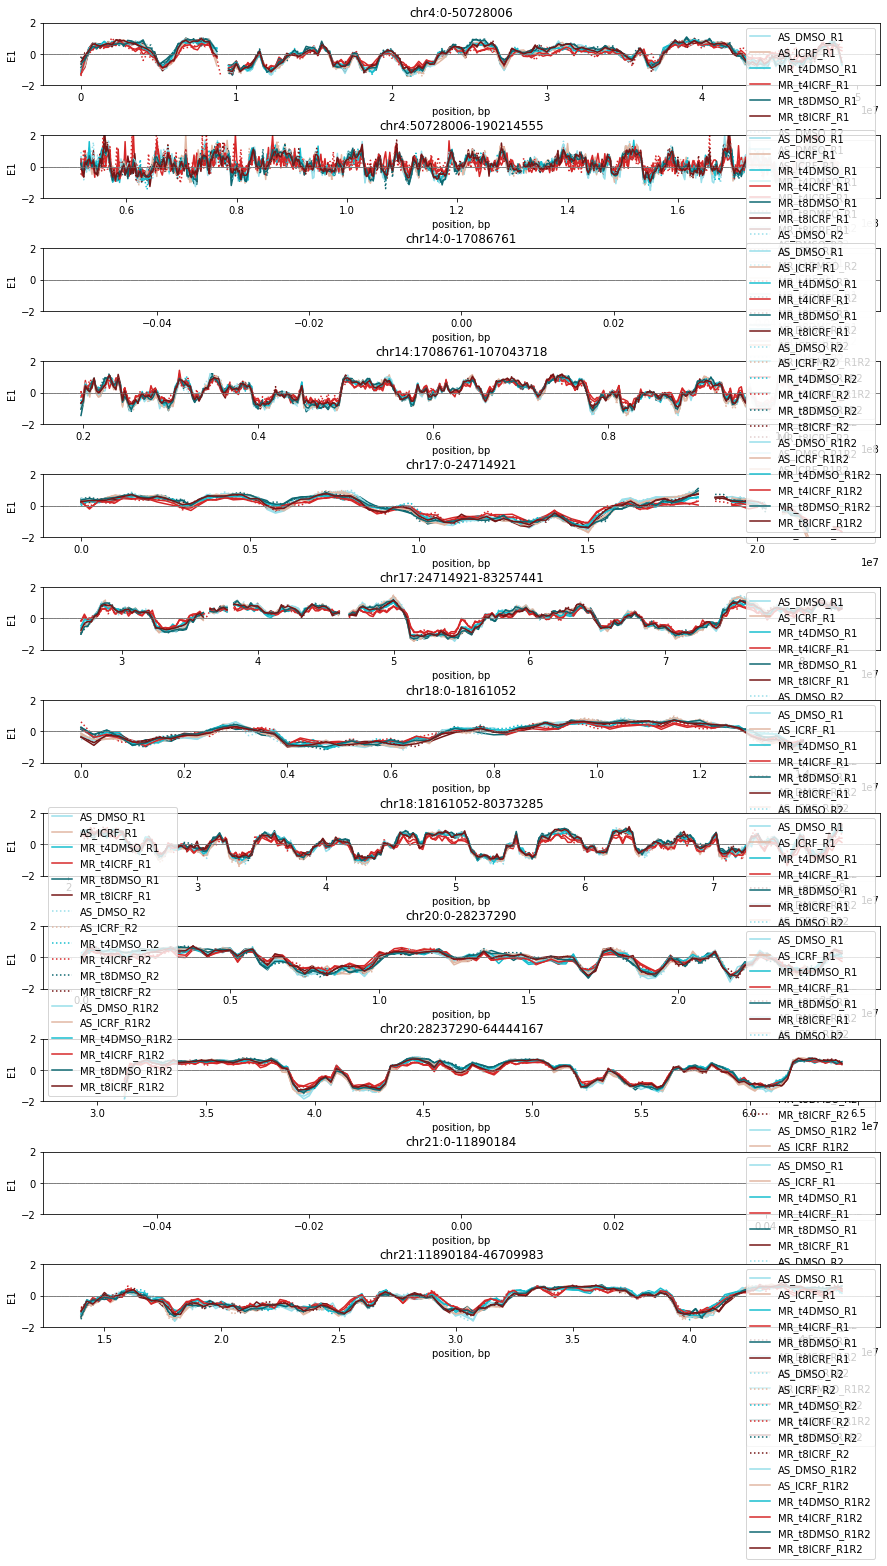

In [35]:
#plot eig1 for each region to make sure they were detecting compartments and not something else...
fig = plt.figure(figsize=(15, 2 * len(hg38_arms)))

gs1 = GridSpec(nrows = len(hg38_arms), ncols = 1, hspace = 0.8)

for i, arm in enumerate(hg38_arms['name']):
    ax = plt.subplot(gs1[i])
    for cond in conditions:
        loc_eig = bioframe.select(eigs[cond], arm)
        ax.plot(
            loc_eig['start'],
            loc_eig['E1'],
            label = cond,
            color = sampleColors[cond],
            ls = sampleLineStyles[cond]
        )
        plt.axhline(0,ls='--',lw=0.5,color='gray')
        plt.ylabel('E1')
        plt.xlabel('position, bp')
        plt.title(arm)
        plt.legend()
        plt.ylim(-2, 2)

plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_eig1_250kb_byarm_mapq30.png', dpi = 300)

In [25]:
for cond in conditions:
    # Save text files
    eigs[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t', index=False, na_rep = 'nan')
    
    # Save bedGraph track
    eigs[cond][['chrom', 'start', 'end', 'E1']].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bedGraph', sep='\t', index=False, na_rep = 'nan', header = False)
    # Save bigwig track
    bioframe.to_bigwig(eigs[cond], hg38_chromsizes, f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bw', 'E1')

In [26]:
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')

In [27]:
import cooltools.lib.plotting

In [28]:
ComboConds_Reorder = [
    'AS_DMSO_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t8DMSO_R1R2',
    'AS_ICRF_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8ICRF_R1R2',
]

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


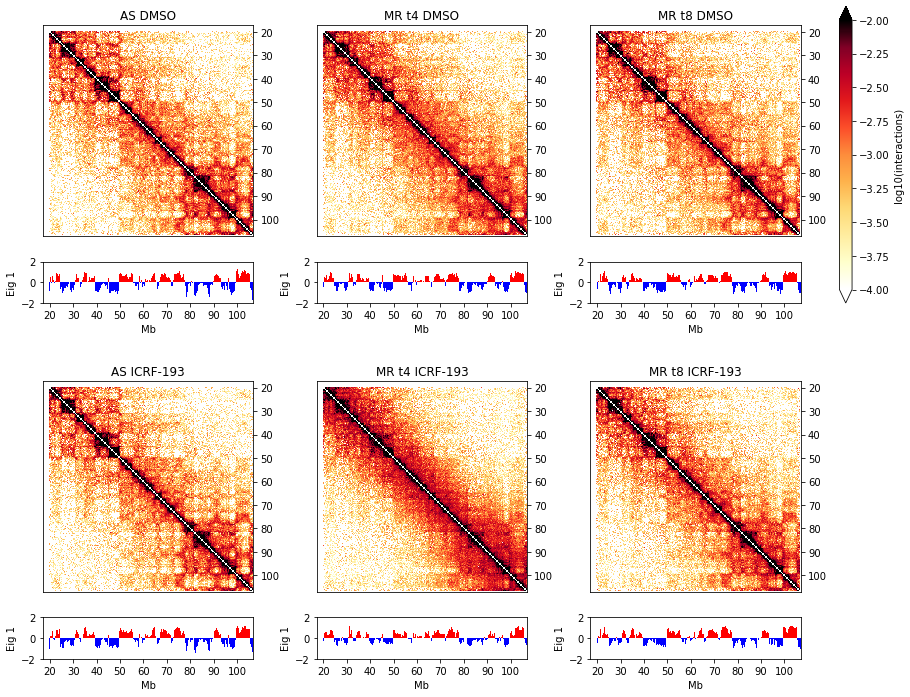

In [36]:
plottingregion = 'chr14:17086761-107043718'
chromarm = ('chr14', 17086761, 107043718)

opts = dict(
    vmin=-4, #change scale range here
    vmax=-2,
    cmap='fall'
)

fig = plt.figure(figsize=(4.5 * 3 + 1, 12))

gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20*len(ComboConds)//2] + [1], wspace=0.1)

gs_cb = GridSpecFromSubplotSpec(nrows=2, ncols=1, wspace = 0.3, subplot_spec = gs00[1])

#how many heatmaps
gs0 = GridSpecFromSubplotSpec(nrows=2, ncols=3, wspace = 0.3, subplot_spec = gs00[0])

for i, cond in enumerate(ComboConds_Reorder):
    gs1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, height_ratios=[6, 1], wspace=0.1, hspace = 0.05, subplot_spec = gs0[i])

    c = clrs250kb[cond]
    cis = c.matrix(balance = True).fetch(plottingregion)
    
    n,j = np.indices(cis.shape)
    n = n.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(n-j) < 2) #fills 2 bins on diagonal with nan
    cis[n[nan_band_selector],j[nan_band_selector]] = np.nan
    
    cisbins = c.bins().fetch(plottingregion)
    mids = cisbins['end'] - binsize/2
    mids = mids.reset_index(drop=True)
    
    #plot heatmap
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow( #can change this to plt.imshow instead probably?
        np.log10(cis), 
        extent=[
            mids[0]/1000000, 
            mids.iloc[-1]/1000000, 
            mids.iloc[-1]/1000000, 
            mids[0]/1000000], 
        **opts)
    ax.xaxis.set_visible(False)
    ax.yaxis.tick_right()    
    ax.set_aspect('equal')
    plt.title(samplePlotNames[cond])
    
    # barplot of eigenvalues

    ax1 = plt.subplot(gs1[1, 0])
    plt.ylim(-2, 2) 
    plt.xlim(chromarm[1]/1000000, chromarm[2]/1000000)
    img2 = ax1.bar(
        x = list((eigs[cond][eigs[cond].chrom == chromarm[0]]['start'] + binsize/2)/1000000), 
        height = list(eigs[cond][eigs[cond].chrom == chromarm[0]]['E1']),
        width = 0.25,
        color=eigs[cond].E1[eigs[cond].chrom == chromarm[0]].apply(lambda x: 'r' if x>0 else 'b')
                  )
    plt.ylabel('Eig 1')
    plt.xlabel('Mb')
    ax1.xaxis.set_ticks(np.arange(20, 110, 10)) #This specifically sets ticks to this range, to match y axis
    fig.add_subplot(ax1)
    
# color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0, 0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(interactions)')

#plt.suptitle(f'Chr14 Heatmaps and Eigen1 200kb Bins')
plt.savefig("{}/figures/220131_ASandMRICRFG1Sort_R1R2Combined_FullChr14Heatmaps_250kbBins_MinusDiag_WithEigen1_Barplot_columns.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [30]:
#Difference heatmap

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


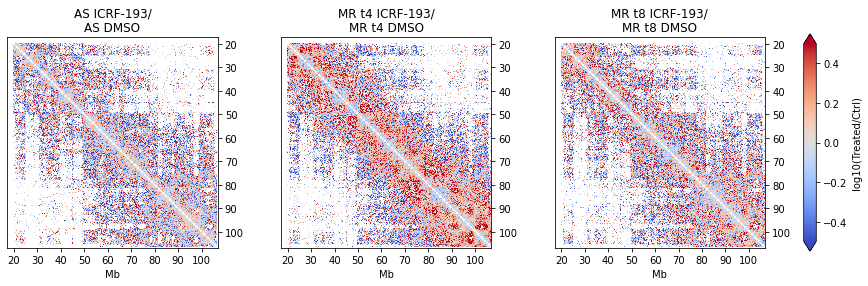

In [31]:
#ratios for main figure - R1 + R2 combined only, 100kb bins
plottingregion = 'chr14:17086761-107043718'
chromarm = ('chr14', 17086761, 107043718)

opts = dict(
    vmin=-0.5,
    vmax=.5,
    cmap='coolwarm'
)

fig = plt.figure(figsize=(4.5 * 3 + 1, 4))

gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20*3] + [1], wspace=0.1)
gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=3, wspace = 0.3, subplot_spec = gs00[0])

for i, (DMSOcond, Treatcond) in enumerate(zip(ComboCtrlConds, ComboTreatConds)):
    
    treatc = clrs250kb[Treatcond]
    treatcis = treatc.matrix(balance = True).fetch(plottingregion)
    treatcisbins = treatc.bins().fetch(plottingregion)
    treatmids = treatcisbins['end'] - binsize/2
    treatmids = treatmids.reset_index(drop=True)
    treatLog10 = np.log10(treatcis)
    
    dmsoc = clrs250kb[DMSOcond]
    dmsocis = dmsoc.matrix(balance = True).fetch(plottingregion)
    dmsocisbins = dmsoc.bins().fetch(plottingregion)
    dmsomids = dmsocisbins['end'] - binsize/2
    dmsomids = dmsomids.reset_index(drop=True)
    dmsoLog10 = np.log10(dmsocis)
    
    ratiocis = treatLog10-dmsoLog10
    k,j = np.indices(ratiocis.shape)
    k = k.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(k-j) < 2) #fills 2 bins on diagonal with nan
    ratiocis[k[nan_band_selector],j[nan_band_selector]] = np.nan
    
    ax = plt.subplot(gs0[i])
    img = ax.matshow(
        ratiocis, extent=[treatmids[0]/1000000, treatmids.iloc[-1]/1000000, treatmids.iloc[-1]/1000000, treatmids[0]/1000000], 
        **opts)
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_right() 
    plt.title(samplePlotNames[Treatcond] + '/\n' + samplePlotNames[DMSOcond])
    plt.xlabel('Mb')
    ax.set_aspect('equal')
    
# color bar in it's own axis, and own gridspace
colorAx = plt.subplot(gs00[1])
cb = plt.colorbar(img, cax = colorAx, extend = 'both')
cb.set_label('log10(Treated/Ctrl)')

plt.savefig("{}/figures/220131_ASandMRICRFG1Sort_R1R2Combined_Chr14DifferenceHeatmaps_minusdiag_250KbBins.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [22]:
#Saddleplots and strength with OWN eig1

In [32]:
#coolers - 250kb bins
binsize = 250000

clr_paths_250kb = {}
for cond in conditions:
    clr_paths_250kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs250kb = {
    cond: cooler.Cooler(clr_paths_250kb[cond]) for cond in conditions
}

In [33]:
for cond in conditions:
    in_fname = clr_paths_250kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 4 -R span[hosts=1] -R select[ib] -R rusage[mem=4000] -R select[rh=8] -N -u erica.hildebrand@umassmed.edu \
        "cooltools compute-expected -p 4 -o $out_fname -t cis --balance --ignore-diags 2 $in_fname --regions $region_fname"


Job <766078> is submitted to queue <short>.
Job <766085> is submitted to queue <short>.
Job <766106> is submitted to queue <short>.
Job <766128> is submitted to queue <short>.
Job <766148> is submitted to queue <short>.
Job <766158> is submitted to queue <short>.
Job <766177> is submitted to queue <short>.
Job <766184> is submitted to queue <short>.
Job <766196> is submitted to queue <short>.
Job <766212> is submitted to queue <short>.
Job <766221> is submitted to queue <short>.
Job <766227> is submitted to queue <short>.
Job <766243> is submitted to queue <short>.
Job <766246> is submitted to queue <short>.
Job <766261> is submitted to queue <short>.
Job <766277> is submitted to queue <short>.
Job <766308> is submitted to queue <short>.
Job <766331> is submitted to queue <short>.


In [ ]:
#Saddle strength - AA, BB, AA + BB

In [37]:
# use this if expected already run, will be much faster
cis_exp = {}

for cond in conditions:
    cis_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep='\t')

In [38]:
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')


In [39]:
# Assign the group to each genomic bin according to its E1, i.e. "digitize" E1.

digitized_ownE1 = {}
hist_ownE1 = {}

for cond in conditions:
    digitized_ownE1[cond], hist_ownE1[cond] = cooltools.saddle.get_digitized(
        track=eigs[cond][['chrom', 'start', 'end', 'E1']],
        qrange = (0.02, 0.98),
        n_bins = 50
    )
    

In [40]:
#Saddle strength by distance

In [41]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [42]:
#make bands - changed distances to be doubling for each bin

#make bands
binsize=250000

bandedges = np.array([0, 20000000, 80000000])
bands = list(zip(bandedges[:-1],bandedges[1:]))
print('bands in bp')
for band in bands:
    print(band)
bands = list(zip((bandedges[:-1]/binsize).astype(int), \
                 (bandedges[1:]/binsize).astype(int)))
print('bands in bins')
for band in bands:
    print(band)

bands in bp
(0, 20000000)
(20000000, 80000000)
bands in bins
(0, 80)
(80, 320)


In [43]:
#Strength by band for own eig1

In [44]:
#Use the function to return saddledata for each band size (just good chromosomes, by arm)

sumsBands_ownE1 = {}
countsBands_ownE1 = {}

for cond in conditions:
    sumsBands_ownE1[cond] = {}
    countsBands_ownE1[cond] = {}
    for band in bands:
        sumsBands_ownE1[cond][band], countsBands_ownE1[cond][band] = cooltools.saddle.get_saddle(
            clr = clrs250kb[cond], 
            expected = cis_exp[cond], 
            contact_type = 'cis',
            digitized_track = digitized_ownE1[cond],
            view_df = hg38_arms.reset_index(drop = True),
            min_diag = band[0],
            max_diag = band[1])
            

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/cooltools/saddle.py:145: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/cooltools/saddle.py:145: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/cooltools/saddle.py:145: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/cooltools/saddle.py:145: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/cooltools/saddle.py:145: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/cooltools-Aug

In [45]:
#Compartment strength - AA vs BB, by distance band

In [46]:
#Own Eig1

In [47]:
#AA vs BB strength
strengthABBands_ownE1 = {}
for cond in conditions:
    strengthABBands_ownE1[cond] = {}
    for band in bands:
        strengthABBands_ownE1[cond][band] = saddle_strengthAB(sumsBands_ownE1[cond][band], countsBands_ownE1[cond][band])

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


In [48]:
#log2 ratio of treatment/control saddle strength within each replicate
sep_log2_treatvsctrl_bands = {}
for comp in ['A', 'B']:
    sep_log2_treatvsctrl_bands[comp] = {}
    for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
        sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'] = {}
        for band in bands:
            sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])
        

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


In [49]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength by band
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

repdict = {
    'AS_DMSO_R1' : 'R1',
    'AS_ICRF_R1' : 'R1',
    'MR_t4DMSO_R1' : 'R1',
    'MR_t4ICRF_R1' : 'R1',
    'MR_t8DMSO_R1' : 'R1',
    'MR_t8ICRF_R1' : 'R1',
    'AS_DMSO_R2' : 'R2',
    'AS_ICRF_R2' : 'R2',
    'MR_t4DMSO_R2' : 'R2',
    'MR_t4ICRF_R2' : 'R2',
    'MR_t8DMSO_R2' : 'R2',
    'MR_t8ICRF_R2' : 'R2',
}

labeldict = {
    'AS_DMSO_R1' : 'AS DMSO',
    'AS_ICRF_R1' : 'AS ICRF-193',
    'MR_t4DMSO_R1' : 'MR t4 DMSO',
    'MR_t4ICRF_R1' : 'MR t4 ICRF-193',
    'MR_t8DMSO_R1' : 'MR t8 DMSO',
    'MR_t8ICRF_R1' : 'MR t8 ICRF-193',
    'AS_DMSO_R2' : 'AS DMSO',
    'AS_ICRF_R2' : 'AS ICRF-193',
    'MR_t4DMSO_R2' : 'MR t4 DMSO',
    'MR_t4ICRF_R2' : 'MR t4 ICRF-193',
    'MR_t8DMSO_R2' : 'MR t8 DMSO',
    'MR_t8ICRF_R2': 'MR t8 ICRF-193',
}

labelPlotColors = {
    'AS DMSO' : '#98DFEA',
    'AS ICRF-193' :  '#E1B7A3',
    'MR t4 DMSO' : '#17BECF',
    'MR t4 ICRF-193' : '#D62728',    
    'MR t8 DMSO' : '#0D6871',
    'MR t8 ICRF-193' : '#751616',    
}

In [50]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength by band
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
    for comp in ['A', 'B']:
        for band in bands:
            comp_score_df = comp_score_df.append({
                'Comparison' : f'{treat}vs{ctrl}', 
                'Distance' : band,
                'Distance_Mb' : f'{[(binsize*x)/1e6 for x in band][0]}-{[(binsize*x)/1e6 for x in band][1]}',
                'Compartment' : comp, 
                'Replicate' : repdict[treat], 
                'Label' : labeldict[treat],
                'Score' : sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band][9]
            }, ignore_index = True)
    

In [51]:
comp_score_df

,Comparison,Compartment,Replicate,Label,Score,Distance,Distance_Mb
0,AS_ICRF_R1vsAS_DMSO_R1,A,R1,AS ICRF-193,-0.041078,"(0, 80)",0.0-20.0
1,AS_ICRF_R1vsAS_DMSO_R1,A,R1,AS ICRF-193,0.171962,"(80, 320)",20.0-80.0
2,AS_ICRF_R1vsAS_DMSO_R1,B,R1,AS ICRF-193,-0.071250,"(0, 80)",0.0-20.0
3,AS_ICRF_R1vsAS_DMSO_R1,B,R1,AS ICRF-193,0.006199,"(80, 320)",20.0-80.0
4,MR_t4ICRF_R1vsMR_t4DMSO_R1,A,R1,MR t4 ICRF-193,-0.634613,"(0, 80)",0.0-20.0
5,MR_t4ICRF_R1vsMR_t4DMSO_R1,A,R1,MR t4 ICRF-193,-0.285270,"(80, 320)",20.0-80.0
6,MR_t4ICRF_R1vsMR_t4DMSO_R1,B,R1,MR t4 ICRF-193,-0.701777,"(0, 80)",0.0-20.0
7,MR_t4ICRF_R1vsMR_t4DMSO_R1,B,R1,MR t4 ICRF-193,-0.316136,"(80, 320)",20.0-80.0
8,MR_t8ICRF_R1vsMR_t8DMSO_R1,A,R1,MR t8 ICRF-193,-0.271379,"(0, 80)",0.0-20.0
9,MR_t8ICRF_R1vsMR_t8DMSO_R1,A,R1,MR t8 ICRF-193,-0.137157,"(80, 320)",20.0-80.0


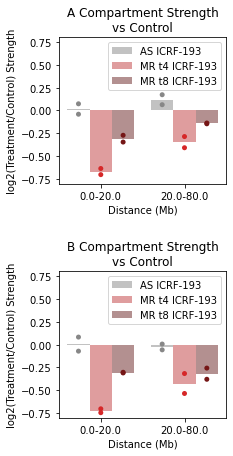

In [53]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#878787','#D62728','#751616'])
gs = GridSpec(nrows= 2, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(3, 7))

for i, comp in enumerate(['A', 'B']):
    ax = plt.subplot(gs[i])

    sns.stripplot(x='Distance_Mb', 
                  y='Score', 
                  hue='Label', 
                  dodge=True, 
                  data=comp_score_df.loc[comp_score_df['Compartment'] == comp, :], 
                  jitter = False, 
                  palette = cmap_bar, 
                  ax = ax)
    ax1 = sns.barplot(x='Distance_Mb', 
                      y='Score', 
                      hue='Label', 
                      data=comp_score_df.loc[comp_score_df['Compartment'] == comp, :], 
                      palette = cmap_bar, 
                      alpha = 0.5, 
                      ci = False, 
                      ax = ax)
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[3:6], labels[3:6])
 
    plt.title(f'{comp} Compartment Strength\nvs Control')
    plt.ylabel('log2(Treatment/Control) Strength')  
    plt.ylim(-.8, 0.8)
    plt.xlabel('Distance (Mb)')
        
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_HiC_CompStrengthByDistance_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [54]:
#Compartment strength analysis vs Control - use own eigens, calculate separately for reach replicate, trans saddle

In [57]:
# create pairwise combinations of chromosomes for calculating average interactions:
regions = bioframe.core.construction.add_ucsc_name_column(bioframe.from_any(hg38_chromsizes))
region_pairs = list(combinations(regions[['chrom', 'start', 'end']].values, 2))

In [58]:
region_pairs

[(array(['chr4', 0, 190214555], dtype=object),
  array(['chr14', 0, 107043718], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr17', 0, 83257441], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr18', 0, 80373285], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr20', 0, 64444167], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr21', 0, 46709983], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr17', 0, 83257441], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr18', 0, 80373285], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr20', 0, 64444167], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr21', 0, 46709983], dtype=object)),
 (array(['chr17', 0, 83257441], dtype=object),
  array(['chr18', 0, 80373285], dtype=object)),
 (array(['chr17', 0, 83257441], dtype=object)

In [59]:
regions.to_csv(f'{outDataDir}/data/hg38_chroms.bed', index = False, sep = '\t', header = None)

In [60]:
for cond in conditions:
    in_fname = clr_paths_250kb[cond]
    region_fname = f'{outDataDir}/data/hg38_chroms.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.trans.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 4 -R span[hosts=1] -R select[ib] -R rusage[mem=4000] -R select[rh=8] -N -u erica.hildebrand@umassmed.edu \
        "cooltools compute-expected -p 4 -o $out_fname -t trans --balance $in_fname --view $region_fname"


Job <842972> is submitted to queue <short>.
Job <842978> is submitted to queue <short>.
Job <842985> is submitted to queue <short>.
Job <842992> is submitted to queue <short>.
Job <842997> is submitted to queue <short>.
Job <843008> is submitted to queue <short>.
Job <843016> is submitted to queue <short>.
Job <843027> is submitted to queue <short>.
Job <843033> is submitted to queue <short>.
Job <843044> is submitted to queue <short>.
Job <843054> is submitted to queue <short>.
Job <843063> is submitted to queue <short>.
Job <843075> is submitted to queue <short>.
Job <843085> is submitted to queue <short>.
Job <843098> is submitted to queue <short>.
Job <843113> is submitted to queue <short>.
Job <843125> is submitted to queue <short>.
Job <843149> is submitted to queue <short>.


In [61]:
#Saddle strength - AA, BB, AA + BB

In [62]:
# use this if expected already run, will be much faster
trans_exp = {}

for cond in conditions:
    trans_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.trans.cli.tsv', sep='\t').set_index(['region1', 'region2'])

In [63]:
trans_exp

{'AS_DMSO_R1':                                      n_valid  count.sum  balanced.sum  \
 region1           region2                                               
 chr4:0-190214555  chr14:0-107043718   260703     9674.0      7.695969   
                   chr17:0-83257441    229329    10503.0      7.551611   
                   chr18:0-80373285    220365     7161.0      6.016855   
                   chr20:0-64444167    177786     7895.0      4.971782   
                   chr21:0-46709983     97857     3404.0      2.872713   
 chr14:0-107043718 chr17:0-83257441    107143    13538.0      6.835951   
                   chr18:0-80373285    102955     8679.0      5.244305   
                   chr20:0-64444167     83062    10297.0      4.633294   
                   chr21:0-46709983     45719     4784.0      2.867266   
 chr17:0-83257441  chr18:0-80373285     90565    11004.0      5.896577   
                   chr20:0-64444167     73066    16487.0      6.484754   
                   chr21

In [64]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 50 # divide remaining 95% of the genome into 50 equisized groups

digitized_ownE1 = {}
hist_ownE1 = {}

for cond in conditions:
    digitized_ownE1[cond], hist_ownE1[cond] = cooltools.saddle.get_digitized(
        eigs[cond][['chrom','start','end','E1']],
        N_GROUPS,
        qrange=(Q_LO,Q_HI))

In [65]:
trans_sums = {}
trans_counts = {}

for cond in conditions:
    trans_sums[cond], trans_counts[cond] = cooltools.saddle.get_saddle(
        clrs250kb[cond],
        trans_exp[cond],
        digitized_ownE1[cond],
        'trans',
        view_df = regions
    )

In [66]:
#Compartment strength - AA vs BB, in trans

In [67]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [68]:
#Own Eig1

In [69]:
#AA vs BB strength, trans
strengthABTrans_ownE1 = {}
for cond in conditions:
    strengthABTrans_ownE1[cond] = saddle_strengthAB(trans_sums[cond], trans_counts[cond])

In [70]:
#log2 ratio of treatment/control saddle strength within each replicate
sep_log2_treatvsctrl_trans = {}
for comp in ['A', 'B']:
    sep_log2_treatvsctrl_trans[comp] = {}
    for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
        sep_log2_treatvsctrl_trans[comp][f'{treat}vs{ctrl}'] = np.log2(strengthABTrans_ownE1[treat][comp]) - np.log2(strengthABTrans_ownE1[ctrl][comp])
        

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


In [71]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength, trans
#5 bin square - top 10% A or B

trans_comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
    for comp in ['A', 'B']:
        trans_comp_score_df = trans_comp_score_df.append({
            'Comparison' : f'{treat}vs{ctrl}', 
            'Compartment' : comp, 
            'Replicate' : repdict[treat], 
            'Label' : labeldict[treat],
            'Score' : sep_log2_treatvsctrl_trans[comp][f'{treat}vs{ctrl}'][4]
        }, ignore_index = True)
    

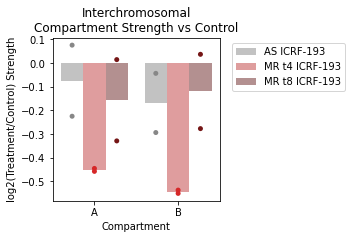

In [72]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot

cmap_bar = sns.color_palette(['#878787','#D62728','#751616'])
gs = GridSpec(nrows= 1, ncols=2, wspace = 0.6, hspace = 0.3)

plt.figure(figsize=(3, 3))

sns.stripplot(x='Compartment', y='Score', hue='Label', dodge=True, data=trans_comp_score_df, jitter = False, palette = cmap_bar)
ax1 = sns.barplot(x='Compartment', y='Score', hue='Label', data=trans_comp_score_df, palette = cmap_bar, alpha = 0.5, ci = False)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[3:6], labels[3:6], bbox_to_anchor=(1.04,1), loc="upper left")
 
plt.title(f'Interchromosomal\nCompartment Strength vs Control')
plt.ylabel('log2(Treatment/Control) Strength')  
plt.xlabel('Compartment')
        
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_HiC_TransCompStrength_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [73]:
conditions

['AS_DMSO_R1',
 'AS_ICRF_R1',
 'MR_t4DMSO_R1',
 'MR_t4ICRF_R1',
 'MR_t8DMSO_R1',
 'MR_t8ICRF_R1',
 'AS_DMSO_R2',
 'AS_ICRF_R2',
 'MR_t4DMSO_R2',
 'MR_t4ICRF_R2',
 'MR_t8DMSO_R2',
 'MR_t8ICRF_R2',
 'AS_DMSO_R1R2',
 'AS_ICRF_R1R2',
 'MR_t4DMSO_R1R2',
 'MR_t4ICRF_R1R2',
 'MR_t8DMSO_R1R2',
 'MR_t8ICRF_R1R2']

In [74]:
#Plot bargraph of avg and dots of replicates - not vs control for AA and BB comp strength, trans
#5 bin square - top 10% A or B

comp_score_df_trans_2 = pd.DataFrame(columns = ['Condition', 'Compartment', 'Replicate', 'Label', 'Score'])

for cond in conditions[0:12]:
    for comp in ['A', 'B']:
        comp_score_df_trans_2 = comp_score_df_trans_2.append({
            'Condition' : cond, 
            'Compartment' : comp, 
            'Replicate' : repdict[cond], 
            'Label' : labeldict[cond],
            'Score' : strengthABTrans_ownE1[cond][comp][4]
        }, ignore_index = True)


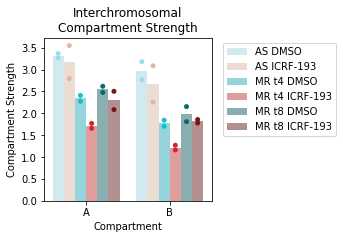

In [75]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#98DFEA', '#E1B7A3', '#17BECF', '#D62728','#0D6871', '#751616'])
gs = GridSpec(nrows= 1, ncols=2, wspace = 0.6, hspace = 0.3)

plt.figure(figsize=(3, 3))

sns.stripplot(x='Compartment', y='Score', hue='Label', dodge=True, data=comp_score_df_trans_2, jitter = False, palette = cmap_bar)
ax1 = sns.barplot(x='Compartment', y='Score', hue='Label', data=comp_score_df_trans_2, palette = cmap_bar, alpha = 0.5, ci = False)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[6:12], labels[6:12], bbox_to_anchor=(1.04,1), loc="upper left")
 
plt.title(f'Interchromosomal\nCompartment Strength')
plt.ylabel('Compartment Strength')  
plt.xlabel('Compartment')
        
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_HiC_TransCompStrength_AllSamples_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [76]:
#Density Plots
#https://cooltools.readthedocs.io/en/latest/notebooks/contacts_vs_distance.html

In [77]:
#Calculate expected on 1kb binned coolers

In [78]:
#coolers - 1kb bins
binsize = 1000

clr_paths_1kb = {}
for cond in conditions:
    clr_paths_1kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'


In [79]:

for cond in conditions:
    in_fname = clr_paths_1kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 8 -R span[hosts=1] -R select[ib] -R rusage[mem=2000] -R select[rh=8] -N -u erica.hildebrand@umassmed.edu \
        "cooltools compute-expected -p 8 -o $out_fname -t cis --balance --ignore-diags 2 $in_fname --regions $region_fname"

Job <865044> is submitted to queue <short>.
Job <865046> is submitted to queue <short>.
Job <865056> is submitted to queue <short>.
Job <865061> is submitted to queue <short>.
Job <865065> is submitted to queue <short>.
Job <865072> is submitted to queue <short>.
Job <865080> is submitted to queue <short>.
Job <865092> is submitted to queue <short>.
Job <865104> is submitted to queue <short>.
Job <865112> is submitted to queue <short>.
Job <865118> is submitted to queue <short>.
Job <865132> is submitted to queue <short>.
Job <865142> is submitted to queue <short>.
Job <865155> is submitted to queue <short>.
Job <865173> is submitted to queue <short>.
Job <865199> is submitted to queue <short>.
Job <865234> is submitted to queue <short>.
Job <865256> is submitted to queue <short>.


In [80]:
#need to fix logbin-expected to properly report the derivative - for now, editing the cli function in cooltools in this env, also submitted an issue on github.

In [81]:
import pandas as pd
import numpy as np
from functools import partial
from cooltools import expected

import click
from cooltools.cli.util import validate_csv

def logbin_expected(
    expected_path,
    output_prefix,
    bins_per_order_magnitude=10,
    bin_layout='fixed',
    min_nvalid=200,
    min_count=50,
    spread_funcs='logstd',
    spread_funcs_slope='std',
    resolution=1000
):
    """
    Logarithmically bin expected values generated using compute_expected for cis data.
    
    This smoothes the data, resulting in clearer plots and more robust analysis results.
    Also calculates derivative after gaussian smoothing.
    For a very detailed escription, see
    https://github.com/open2c/cooltools/blob/51b95c3bed8d00a5f1f91370fc5192d9a7face7c/cooltools/expected.py#L988
    EXPECTED_PATH : The paths to a .tsv file with output of compute_expected.
    Must include a header. Use the '::' syntax to specify a summary column name.
    
    OUTPUT_PREFIX: Output file name prefix to store the logbinned expected
    (prefix.log.tsv) and derivative (prefix.der.tsv) in the tsv format."
    """

    # unpack expected path and name as generated by click's callback to validate_csv:
    expected_path, exp_summary_name = expected_path
    # that's what we expect as column names:
    expected_columns = ["region", "diag", "n_valid", "count.sum", exp_summary_name]
    if exp_summary_name == "count.sum":
        expected_columns = ["region", "diag", "n_valid", exp_summary_name]
    # expected dtype as a rudimentary form of validation:
    expected_dtype = {
        "region": np.str,
        "diag": np.int64,
        "n_valid": np.int64,
        "count.sum": np.float64,
        exp_summary_name: np.float64,
    }

    # use 'usecols' as a rudimentary form of validation,
    # and dtype. Keep 'comment' and 'verbose' - explicit,
    # as we may use them later:
    cvd = pd.read_csv(
        expected_path,
        usecols=expected_columns,
        dtype=expected_dtype,
        comment=None,
        sep='\t',
        verbose=False,
    )

    # name of the column with Probability of contacts is
    # based on the name of the column  with the diagonal-summary
    # stats in the input expected DataFrame:
    exp_summary_base, *_ = exp_summary_name.split(".")
    Pc_name = f"{exp_summary_base}.avg"

    lb_cvd, lb_slopes, lb_distbins = expected.logbin_expected(
        cvd,
        summary_name=exp_summary_name,
        bins_per_order_magnitude=bins_per_order_magnitude,
        bin_layout=bin_layout,
        min_nvalid=min_nvalid,
        min_count=min_count
    )
    # combine Probabilities of contact for the regions:
    lb_cvd_agg, lb_slopes_agg = expected.combine_binned_expected(
        lb_cvd,
        Pc_name=Pc_name,
        binned_exp_slope=lb_slopes,
        spread_funcs=spread_funcs,
        spread_funcs_slope=spread_funcs_slope
    )
    if resolution is not None:
        lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * resolution
        lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * resolution

    lb_cvd_agg.to_csv(
        f'{output_prefix}.log.tsv',
        sep="\t",
        index=False,
        na_rep="nan",
    )
    lb_slopes_agg.to_csv(
        f'{output_prefix}.der.tsv',
        sep="\t",
        index=False,
        na_rep="nan",
    )

In [83]:
#log bin expected values

for cond in conditions:
    in_fname = (f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', 'balanced.sum')
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli'
    logbin_expected(expected_path = in_fname, output_prefix = out_fname)

/home/eh37w/bin/miniconda3/envs/cooltools-Aug2021-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [84]:
#read in log binned expected for plotting
log_exp = {}
for cond in conditions:
    log_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.log.tsv', sep = '\t')

In [85]:
#read in derivative, log binned for plotting
log_der = {}
for cond in conditions:
    log_der[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.der.tsv', sep = '\t')

In [86]:
#Add Density column - (balanced.avg * n_valid)/sum(balanced.avg * n_valid)) 
for cond in conditions:
    log_exp[cond]['density'] = (
        log_exp[cond]['balanced.avg'] * log_exp[cond]['n_valid'])/np.nansum(
        log_exp[cond]['balanced.avg'] * log_exp[cond]['n_valid'])

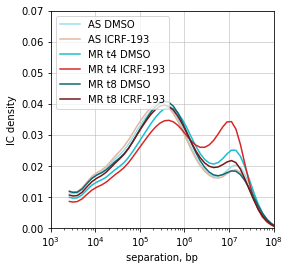

In [87]:
#Smooth density before plotting, on log bins like for scaling. Then convert back to linear so can use semilogx
from cooltools.lib import numutils
smoothf = der_smooth_function_combined=lambda x: numutils.robust_gauss_filter(x, 1.3)

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in ComboConds:
    ax.semilogx(
        10**smoothf(np.log10(log_exp[cond]['s_bp'])),
        smoothf(log_exp[cond]['density']),
        color = sampleColors[cond],
        label = samplePlotNames[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='IC density',
        xlim=(1e3,1e8),
        ylim=(0, 0.07)
    )

    ax.grid(lw=0.5)
    ax.legend()
    #ax.set_aspect(100)
    
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_Density.png', dpi = 300, bbox_inches = "tight")

In [88]:
SepConds

['AS_DMSO_R1',
 'AS_ICRF_R1',
 'MR_t4DMSO_R1',
 'MR_t4ICRF_R1',
 'MR_t8DMSO_R1',
 'MR_t8ICRF_R1',
 'AS_DMSO_R2',
 'AS_ICRF_R2',
 'MR_t4DMSO_R2',
 'MR_t4ICRF_R2',
 'MR_t8DMSO_R2',
 'MR_t8ICRF_R2']

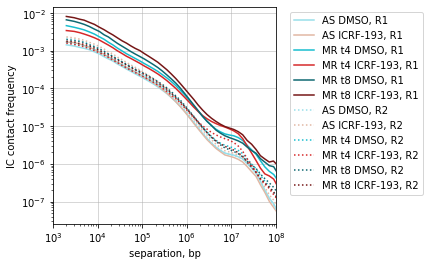

In [89]:
#Plot scaling and slope separately

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in SepConds:
    ax.loglog(
        log_exp[cond]['s_bp'],
        log_exp[cond]['balanced.avg'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        linestyle = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency',
        xlim=(1e3,1e8)
    )
    #ax.set_aspect(1.0)
    ax.grid(lw=0.5)
    ax.legend(bbox_to_anchor=(1.04,1))
    
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_Scaling_Separate.png', dpi = 300, bbox_inches = "tight")

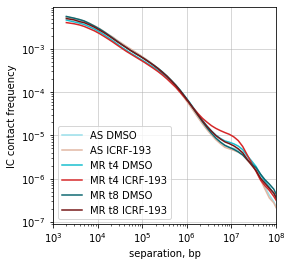

In [90]:
#Plot scaling and slope separately

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in ComboConds:
    ax.loglog(
        log_exp[cond]['s_bp'],
        log_exp[cond]['balanced.avg'],
        '-',
        color = sampleColors[cond],
        label = samplePlotNames[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency',
        xlim=(1e3,1e8)
    )
    #ax.set_aspect(1.0)
    ax.grid(lw=0.5)
    ax.legend()
    
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_Scaling_Combo.png', dpi = 300, bbox_inches = "tight")

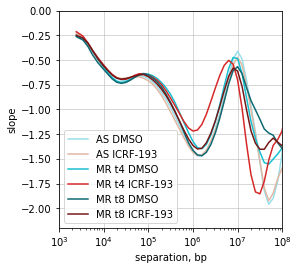

In [98]:
#Plot scaling and slope separately

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in ComboConds:
    ax.semilogx(
        log_der[cond]['s_bp'],
        log_der[cond]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='slope',
        ylim=(-2.2, 0),
        xlim=(1e3,1e8)
    )

    ax.grid(lw=0.5)
    #ax.set_aspect(1)
    plt.legend()
    
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_ScalingSlope_Combo.png', dpi = 300, bbox_inches = "tight")

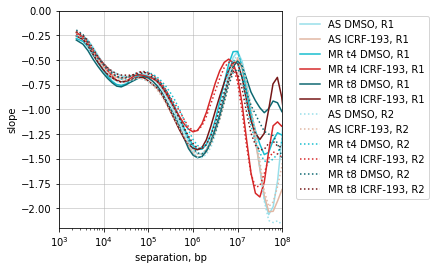

In [94]:
#Plot scaling and slope separately

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in SepConds:
    ax.semilogx(
        log_der[cond]['s_bp'],
        log_der[cond]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        linestyle = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='slope',
        ylim=(-2.2, 0),
        xlim=(1e3,1e8)
    )

    ax.grid(lw=0.5)
    #ax.set_aspect(1)
    plt.legend(bbox_to_anchor=(1.04,1))
    
plt.savefig(f'{outDataDir}/figures/220131_ASandMRICRFG1Sort_R1R2_ScalingSlope_Separate.png', dpi = 300, bbox_inches = "tight")

In [6]:
#Call insulation, pileup at control boundaries

In [8]:
#coolers - 10kb bins
binsize = 10000

clr_paths_10kb = {}
for cond in conditions:
    clr_paths_10kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs10kb = {
    cond: cooler.Cooler(clr_paths_10kb[cond]) for cond in conditions
}

In [9]:
good_chroms = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21']

In [12]:
#call insulation
#https://cooltools.readthedocs.io/en/latest/notebooks/insulation_and_boundaries.html
windows = [250000]
insulation = {}

for cond in conditions:
    insulation[cond] = calculate_insulation_score(clrs10kb[cond], windows, verbose=True, ignore_diags = 2, chromosomes = good_chroms)

INFO:root:Processing chr4
INFO:root:Processing chr14
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr4
INFO:root:Processing chr14
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr4
INFO:root:Processing chr14
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr4
INFO:root:Processing chr14
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr4
INFO:root:Processing chr14
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr4
INFO:root:Processing chr14
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr4
INFO:roo

In [13]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

(35000000.0, 40000000.0)

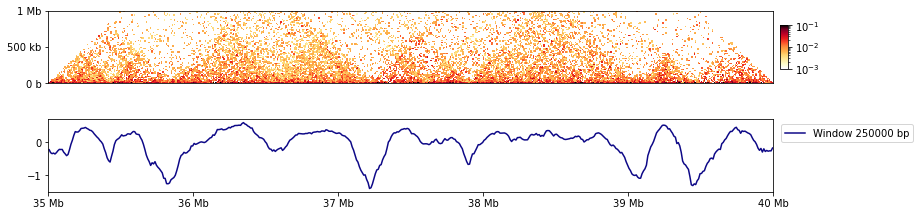

In [15]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid import make_axes_locatable
import bioframe

region = ('chr14', 35000000, 40000000)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clrs10kb['MR_t8DMSO_R1R2'].matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(20, 4))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 1000000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation['MR_t8DMSO_R1R2'], region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region['log2_insulation_score_250000'], label='Window 250000 bp')

ins_ax.legend(bbox_to_anchor=(1.2,1), loc="upper right")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

In [19]:
bounds = {}
for cond in conditions:
    bounds[cond] = find_boundaries(insulation[cond])

In [20]:
bounds[cond].iloc[1000:1005]

,chrom,start,end,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000
1000,chr4,10000000,10010000,False,-0.039514,622.0,NaN
1001,chr4,10010000,10020000,False,-0.097661,622.0,NaN
1002,chr4,10020000,10030000,False,-0.147234,622.0,NaN
1003,chr4,10030000,10040000,False,-0.171500,622.0,0.018895
1004,chr4,10040000,10050000,False,-0.152605,622.0,NaN


(35000000.0, 40000000.0)

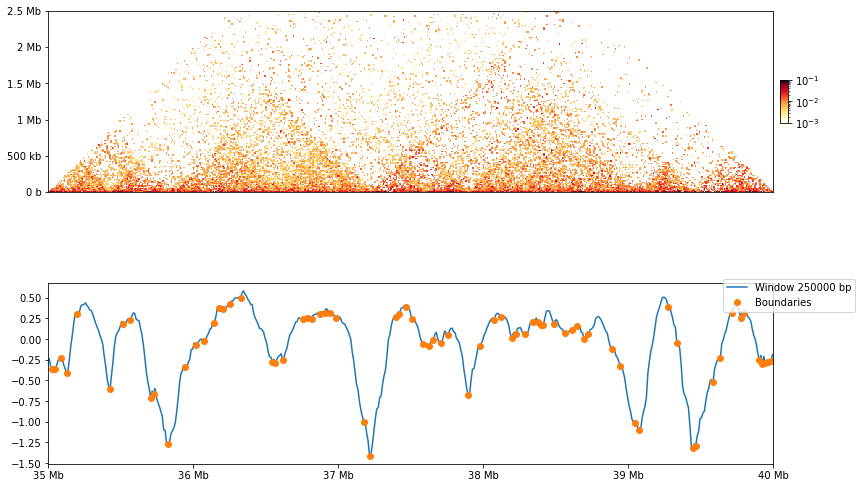

In [21]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 2500000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(bounds['MR_t8DMSO_R1R2'], region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region['log2_insulation_score_250000'], label='Window 250000 bp')
boundaries = insul_region[~np.isnan(insul_region['boundary_strength_250000'])]
ins_ax.plot(boundaries[['start', 'end']].mean(axis=1), boundaries['log2_insulation_score_250000'], 'o', label='Boundaries')

ins_ax.legend(bbox_to_anchor=(1.12, 1.05), loc='upper right')

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

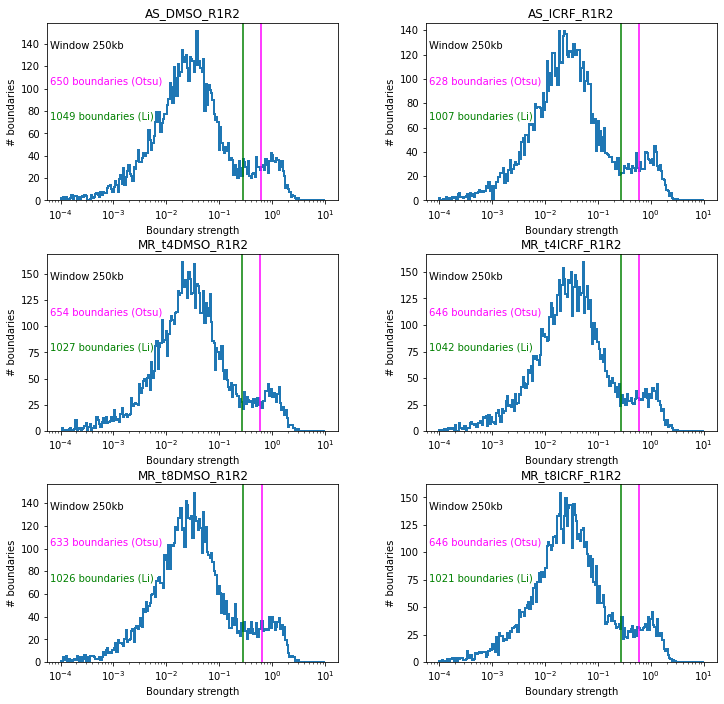

In [23]:
from skimage.filters import threshold_li, threshold_otsu

histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

fig = plt.figure(figsize=(12, 16))

gs0 = GridSpec(nrows = 4, ncols = 2, wspace=0.3, hspace = 0.3)

thresholds_li = {}
thresholds_otsu = {}
bounds_li = {}
bounds_otsu = {}

for i, cond in enumerate(ComboConds):
    gs1 = GridSpecFromSubplotSpec(nrows=len(windows), ncols=1, wspace = 0.3, hspace = 1, subplot_spec = gs0[i])

    thresholds_li[cond] = {}
    thresholds_otsu[cond] = {}
    bounds_li[cond] = {}
    bounds_otsu[cond] = {}

    for i, w in enumerate(windows):
        ax = plt.subplot(gs1[i])
        ax.hist(
            bounds[cond][f'boundary_strength_{w}'],
            **histkwargs
        )
        thresholds_li[cond][w] = threshold_li(bounds[cond][f'boundary_strength_{w}'].dropna().values)
        thresholds_otsu[cond][w] = threshold_otsu(bounds[cond][f'boundary_strength_{w}'].dropna().values)
        n_boundaries_li = (bounds[cond][f'boundary_strength_{w}'].dropna()>=thresholds_li[cond][w]).sum()
        bounds_li[cond][w] = bounds[cond][(bounds[cond][f'boundary_strength_{w}']>=thresholds_li[cond][w])]
        n_boundaries_otsu = (bounds[cond][f'boundary_strength_{w}'].dropna()>=thresholds_otsu[cond][w]).sum()
        bounds_otsu[cond][w] = bounds[cond][(bounds[cond][f'boundary_strength_{w}']>=thresholds_otsu[cond][w])]

        ax.axvline(thresholds_li[cond][w], c='green')
        ax.axvline(thresholds_otsu[cond][w], c='magenta')
        ax.text(0.01, 0.9,
                 f'Window {w//1000}kb',
                 ha='left',
                 va='top',
                 transform=ax.transAxes)
        ax.text(0.01, 0.7,
                f'{n_boundaries_otsu} boundaries (Otsu)',
                c='magenta',
                ha='left',
                va='top',
                transform=ax.transAxes)
        ax.text(0.01, 0.5,
                f'{n_boundaries_li} boundaries (Li)',
                c='green',
                ha='left',
                va='top',
                transform=ax.transAxes)

        ax.set(
            xscale='log',
            ylabel='# boundaries'
        )

        ax.set(xlabel='Boundary strength')
        plt.title(cond)
    
plt.savefig(f'{outDataDir}/figures/220201_MRandASDMSOvsICRF_AllCond_BoundaryThresholds.png', dpi = 300, 
            bbox_inches = 'tight')

In [24]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')

In [25]:
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]

In [26]:
for cond in conditions:
    for w in windows:
        bioframe.to_bigwig(insulation[cond], hg38_chromsizes,
            f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_{w}.bw', 
            f'log2_insulation_score_{w}')

In [28]:
import bbi

In [33]:
# Create stackup. flank = .5Mb, nbins = 100, 250kb window, 10kb hi-c resolution
flank = 500000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
ins_pileup_signal = {}
for cond in conditions:
    ins_pileup_signal[cond] = bbi.stackup(
        f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_250000.bw',
        bounds_otsu['MR_t8DMSO_R1R2'][250000].chrom,
        bounds_otsu['MR_t8DMSO_R1R2'][250000].start-flank,
        bounds_otsu['MR_t8DMSO_R1R2'][250000].end+flank, bins=nbins)

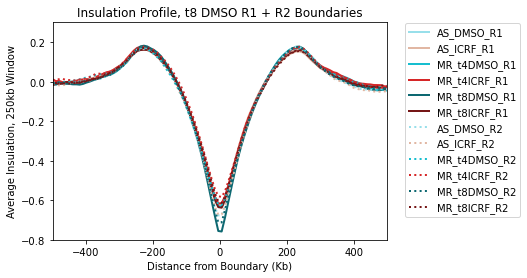

In [34]:
f, ax = plt.subplots(figsize=[6, 4])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in SepConds:
    ax.plot(x, np.nanmean(ins_pileup_signal[cond], axis=0), color = sampleColors[cond], label = cond, 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-.8, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.title('Insulation Profile, t8 DMSO R1 + R2 Boundaries')
plt.ylabel('Average Insulation, 250kb Window')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/220201_MRandASDMSOvsICRF_InsulationPileup_t8DMSOBoundaries.png', dpi = 300, 
            bbox_inches = 'tight')

In [ ]:
#separate out TAD vs Compartment boundaries

In [36]:
#called boundaries from cooler compartments (with gene density)
binsize_comp = 250000

eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize_comp//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t')

#calling A vs B compartments in each sample
eigsA = {}
for cond in conditions:
    eigsA[cond] = eigs[cond][eigs[cond]['E1'] > 0]
    
eigsB = {}
for cond in conditions:
    eigsB[cond] = eigs[cond][eigs[cond]['E1'] < 0]

compRangesA = {}
for cond in conditions:
    compRangesA[cond] = bioframe.merge(pd.DataFrame(data = {
        'chrom' : eigsA[cond].chrom,
        'start' : eigsA[cond].start,
        'end' : eigsA[cond].end,
        'name' : '.',
        'score' : '.',
        'strand' : '+'
    }))
    
compRangesB = {}
for cond in conditions:
    compRangesB[cond] = bioframe.merge(pd.DataFrame(data = {
        'chrom' : eigsB[cond].chrom,
        'start' : eigsB[cond].start,
        'end' : eigsB[cond].end,
        'name' : '.',
        'score' : '.',
        'strand' : '+'
    }))

In [37]:
#calling compartment boundaries in each sample
#Calculate which bins flank sign changes - on same chromosome. 

compBounds = {}
signsAll = {}

for cond in conditions:    
    signsAll[cond] = pd.DataFrame(data = {
        'Chrom1' : eigs[cond]['chrom'][0:-1].reset_index(drop = True),
        'Bin1Start' : eigs[cond]['start'][0:-1].reset_index(drop = True),
        'Bin1End' : eigs[cond]['end'][0:-1].reset_index(drop = True),
        'Bin1E1' : eigs[cond]['E1'][0:-1].reset_index(drop = True),
        'Chrom2' : eigs[cond]['chrom'][1:].reset_index(drop = True),
        'Bin2Start' : eigs[cond]['start'][1:].reset_index(drop = True),
        'Bin2End' : eigs[cond]['end'][1:].reset_index(drop = True),  
        'Bin2E1' : eigs[cond]['E1'][1:].reset_index(drop = True),
        'sign' : (eigs[cond]['E1'][0:-1].reset_index(drop = True) * eigs[cond]['E1'][1:].reset_index(drop = True))
        })
    signsAll[cond].apply(pd.to_numeric, errors='ignore')
    signsAll[cond] = signsAll[cond].astype({"Bin1Start": int, "Bin1End": int, "Bin2Start": int, "Bin2End": int})

    compBounds[cond] = signsAll[cond][(signsAll[cond]['sign'] < 0) &
                                      (signsAll[cond]['Chrom1'] == signsAll[cond]['Chrom2']) 
                                     ]

In [38]:
compBoundsRanges = {}
for cond in conditions:
    compBoundsRanges[cond] = pd.DataFrame(data = {
        'chrom' : compBounds[cond].Chrom1,
        'start' : compBounds[cond].Bin1Start,
        'end' : compBounds[cond].Bin2End,
        'name' : '.',
        'score' : compBounds[cond].sign,
        'strand' : '+'
    })

In [39]:
compBoundsRanges['MR_t4DMSO_R1']

,chrom,start,end,name,score,strand
1,chr4,250000,750000,.,-0.091403,+
17,chr4,4250000,4750000,.,-0.002670,+
23,chr4,5750000,6250000,.,-0.071820,+
53,chr4,13250000,13750000,.,-0.006791,+
54,chr4,13500000,14000000,.,-0.003200,+
...,...,...,...,...,...,...
2232,chr21,32000000,32500000,.,-0.061509,+
2254,chr21,37500000,38000000,.,-0.002213,+
2255,chr21,37750000,38250000,.,-0.001250,+
2261,chr21,39250000,39750000,.,-0.019405,+


In [40]:
bounds_otsu[cond][250000]

,chrom,start,end,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000
101,chr4,1010000,1020000,False,-0.419616,622.0,1.052725
171,chr4,1710000,1720000,False,-1.029594,622.0,1.878720
221,chr4,2210000,2220000,False,-0.078072,622.0,0.599558
308,chr4,3080000,3090000,False,-0.351600,622.0,0.892254
394,chr4,3940000,3950000,False,-0.611508,472.0,1.217556
...,...,...,...,...,...,...,...
4212,chr21,42120000,42130000,False,-0.423317,622.0,0.759398
4255,chr21,42550000,42560000,False,-0.145053,622.0,0.604981
4285,chr21,42850000,42860000,False,-0.597038,472.0,1.062863
4515,chr21,45150000,45160000,False,-0.393445,622.0,1.059110


In [41]:
tadOnlyBoundaries = {}
overlapCompBoundaries = {}

for cond in ComboConds:
    insBoundaries = bounds_otsu[cond][250000].copy()
    compBoundaries = compBoundsRanges[cond].copy()
    overlapBounds = bioframe.overlap(insBoundaries, compBoundaries, how = 'inner').iloc[:, 0:4]
    overlapBounds.columns = ['chrom', 'start', 'end', 'boundary_strength_250000']
    overlapCompBoundaries[cond] = overlapBounds.drop_duplicates()
    tadOnlyBoundaries[cond] = bioframe.subtract(insBoundaries, overlapCompBoundaries[cond]).drop_duplicates()

In [42]:
#save the comp vs tad insulation boundaries
for cond in ComboConds:
    overlapCompBoundaries[cond].to_csv(
        f'{outDataDir}/data/{long_names[cond]}.compartmentOverlap_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)
    tadOnlyBoundaries[cond].to_csv(    
        f'{outDataDir}/data/{long_names[cond]}.TADonly_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)

In [43]:
#read in comp vs tad insulation boundaries
tadOnlyBoundaries = {}
overlapCompBoundaries = {}

for cond in ComboConds:
    overlapCompBoundaries[cond] = pd.read_csv(
        f'{outDataDir}/data/{long_names[cond]}.compartmentOverlap_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t")
    tadOnlyBoundaries[cond] = pd.read_csv(    
        f'{outDataDir}/data/{long_names[cond]}.TADonly_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t")
    

In [44]:
# Create stackup. flank = .5Mb, nbins = 100, 250kb window, 10kb hi-c resolution, TAD only boundaries
flank = 500000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
ins_pileup_signal_TAD = {}
for cond in conditions:
    ins_pileup_signal_TAD[cond] = bbi.stackup(
        f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_250000.bw',
        tadOnlyBoundaries['MR_t8DMSO_R1R2'].chrom,
        tadOnlyBoundaries['MR_t8DMSO_R1R2'].start-flank,
        tadOnlyBoundaries['MR_t8DMSO_R1R2'].end+flank, bins=nbins)

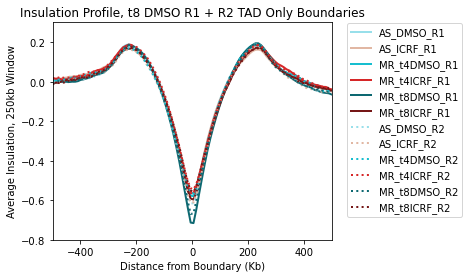

In [46]:
f, ax = plt.subplots(figsize=[5, 4])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in SepConds:
    ax.plot(x, np.nanmean(ins_pileup_signal_TAD[cond], axis=0), color = sampleColors[cond], label = cond, 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-.8, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.title('Insulation Profile, t8 DMSO R1 + R2 TAD Only Boundaries')
plt.ylabel('Average Insulation, 250kb Window')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/220201_MRandASDMSOvsICRF_InsulationPileup_t8DMSOTADOnlyBoundaries.png', dpi = 300, 
            bbox_inches = 'tight')

In [47]:
#Loop pileups

In [48]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))


In [49]:
hg38_arms = hg38_arms[hg38_arms['chrom'].isin(good_chroms)]

In [50]:
#https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html
#Loop pileups - use loops that I called from deep 4DN data on this cell line

In [51]:
dot_file = '/nl/umw_job_dekker/users/eh37w/Topo-Inhib/Manuscript_Organized_August2021/4DNData/data/4DN_HeLaS3_merged5and10kbbins_dots.txt.postproc.bedpe'

In [52]:
# Read dot data
dots = pd.read_table(dot_file)
dots['mid1'] = (dots['start1'] + dots['end1'])//2
dots['mid2'] = (dots['start2'] + dots['end2'])//2

In [53]:
# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:
import cooltools.lib.plotting

In [54]:
pd.DataFrame(hg38_arms).to_csv(f'{outDataDir}/data/hg38_goodchroms_arms.bed', sep = '\t', index = False, header = False)

In [55]:
for cond in conditions:
    in_fname = clr_paths_10kb[cond]
    region_fname = f'{outDataDir}/data/hg38_goodchroms_arms.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 8 -R span[hosts=1] -R select[ib] -R rusage[mem=2000] -R select["rh=8"] -N -u erica.hildebrand@umassmed.edu \
        "cooltools compute-expected -p 8 -o $out_fname -t cis --balance --ignore-diags 2 $in_fname --regions $region_fname"


Job <2909423> is submitted to queue <short>.
Job <2909424> is submitted to queue <short>.
Job <2909425> is submitted to queue <short>.
Job <2909426> is submitted to queue <short>.
Job <2909427> is submitted to queue <short>.
Job <2909428> is submitted to queue <short>.
Job <2909429> is submitted to queue <short>.
Job <2909430> is submitted to queue <short>.
Job <2909431> is submitted to queue <short>.
Job <2909432> is submitted to queue <short>.
Job <2909433> is submitted to queue <short>.
Job <2909434> is submitted to queue <short>.
Job <2909435> is submitted to queue <short>.
Job <2909436> is submitted to queue <short>.
Job <2909437> is submitted to queue <short>.
Job <2909438> is submitted to queue <short>.
Job <2909439> is submitted to queue <short>.
Job <2909440> is submitted to queue <short>.


In [58]:
flank = 200000

windows1 = snipping.make_bin_aligned_windows(
    binsize,
    dots['chrom1'],
    dots['mid1'],
    flank_bp=flank)

windows2 = snipping.make_bin_aligned_windows(
    binsize,
    dots['chrom2'],
    dots['mid2'],
    flank_bp=flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, hg38_arms)

In [59]:
windows = windows.dropna()

In [60]:
# use this if expected already run, will be much faster
cis_exp_cli = {}

for cond in conditions:
    cis_exp_cli[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep = '\t')

In [61]:
# Set up parallelization
import multiprocess
nthreads = 8

In [62]:
mtx = {}

for cond in ComboConds:

    oe_snipper = cooltools.snipping.ObsExpSnipper(clrs10kb[cond], cis_exp_cli[cond], view_df = hg38_arms)

    # create the stack of snips:
    with multiprocess.Pool(nthreads) as pool:
        stack = cooltools.snipping.pileup(
                windows,
                oe_snipper.select,
                oe_snipper.snip,
                map=pool.map
                )

    mtx[cond] = np.nanmean(stack, axis=2)


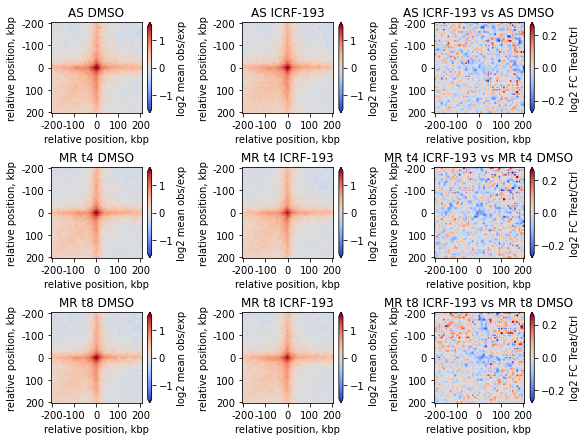

In [85]:
#Pileup Hi-C data at loops
binsize = 10000
gs = GridSpec(nrows= 3, ncols=3, wspace = .6, hspace = 0.6)
plt.figure(figsize=(9, 7))

for i, cond in enumerate(ComboCtrlConds):
    ax = plt.subplot(gs[i, 0])
    img = ax.imshow(
        np.log2(mtx[cond]),
        vmax = 1.5,
        vmin = -1.5,
        cmap='coolwarm')

    plt.colorbar(img, label = 'log2 mean obs/exp', extend = 'both')
    ticks_pixels = np.linspace(0, flank*2//binsize,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*binsize//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title(samplePlotNames[cond])
    
for i, cond in enumerate(ComboTreatConds):
    ax = plt.subplot(gs[i, 1])
    img = ax.imshow(
        np.log2(mtx[cond]),
        vmax = 1.5,
        vmin = -1.5,
        cmap='coolwarm')

    plt.colorbar(img, label = 'log2 mean obs/exp', extend = 'both')
    ticks_pixels = np.linspace(0, flank*2//binsize,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*binsize//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title(samplePlotNames[cond])

for i, (treatcond, ctrlcond) in enumerate(zip(ComboTreatConds, ComboCtrlConds)):
    ax = plt.subplot(gs[i, 2])
    img = ax.imshow(
        (np.log2(mtx[treatcond]) - np.log2(mtx[ctrlcond])),
        vmax = .25,
        vmin = -.25,
        cmap='coolwarm')

    plt.colorbar(img, label = 'log2 FC Treat/Ctrl', extend = 'both')
    ticks_pixels = np.linspace(0, flank*2//binsize,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*binsize//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title(f'{samplePlotNames[treatcond]} vs {samplePlotNames[ctrlcond]}')
    
plt.savefig("{}/figures/220201_MRandASICRFHeLa_R1R2Combined_LoopPileup_4DNDeepHeLaloops.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')